Notes diverses

- Si PCA : à faire après scaling
- Penser à une approche ensembliste si on a des modèles qui performent différemment selon les classes


# Configuration

En phase de développement, il peut être utile de faire en sorte que tout changement dans les modules importés soit immédiatement pris en compte dans le notebook.

In [1]:
%load_ext autoreload
%autoreload 2

Ci-dessous on définit le fichier permettant de charger notre jeu de données.

In [2]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

Ensuite on définit quelques variables globales permettant de choisir ce qu'on souhaite exécuter ou non dans le notebook.

In [3]:
# MLflow
ACTIVATE_MLFLOW = True
# MLFLOW_URI = "http://truenas:35000"
MLFLOW_URI = "http://mlflow.philippemarechal.org:35000"
# MLFLOW_URI = "http://localhost:8080"

# Pré-chargement des modules
PRELOAD_MODULES = True

# Chargement et préparation du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [4]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10.head())

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False


On constate que les chemins stockés dans le fichier .csv contiennent un mélange de séparateurs '/' et '\\'.

On décide d'harmoniser le tout en utilisant '/'.

In [5]:
df_pvf10["Chemin"] = df_pvf10["Chemin"].str.replace("\\", "/")

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [6]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

## Sélection des images de format carré

In [7]:
df_pvf10 = df_pvf10.loc[df_pvf10["Doute_Carre"] == False]

In [8]:
display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Pré-chargement des images (augmentées inclues)

In [9]:
if PRELOAD_MODULES:

    from pathlib import Path
    from sep24_cds_pv.features.pvmodule import PVModule

    images_extension = Path(df_pvf10.loc[0, "Chemin"]).suffix
    dataset_basepath = Path(df_pvf10.loc[0, "Chemin"]).parents[2]

    for image_path in dataset_basepath.glob(f"**/*{images_extension}"):
        
        module = PVModule.get_module(image_path)

    print(f"Number of total images found: {len(PVModule.get_known_modules())}")

Number of total images found: 9597


## Chargement des images (objets PVModule)

In [10]:
from pathlib import Path
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    module = PVModule.get_module(image_path)

    modules.append(module)

Nombre de modules chargés

In [11]:
print(f"Number of modules for the dataset: {len(modules)}")

Number of modules for the dataset: 5338


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: (110, 60)


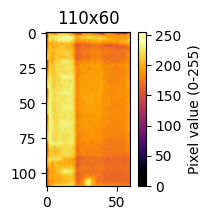

In [12]:
module = modules[0]
print(module)
module.plot()

# Définition des extracteurs

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import time

## Indicateurs statistiques "basiques"

In [14]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class BaseStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_stats_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les dict stats
        stats_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Stockage du dict stats
            module.extract_stats()
            stats_dicts.append(module.stats)
        # On renvoie le dataframe des dict stats
        return pd.DataFrame.from_records(stats_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des indicateurs statistiques.

In [15]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_stats()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.35 minutes (0.003915900190745726 secondes par module)


## Histogramme

In [16]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class HistogramExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_histogram_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les vecteurs histogramme
        histo_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            module.extract_histogram()
            # Stockage du dict histogramme
            histo_dicts.append(module.histogram_dict)
        # On renvoie le dataframe des vecteurs stats
        return pd.DataFrame.from_records(histo_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des histogrammes.

In [17]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_histogram()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.04 minutes (0.000438773439992631 secondes par module)


## Vecteurs GLCM 

In [18]:
# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = PVModule.get_glcm_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vector_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_glcm()
            glcm_vector_dicts.append(module.glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame.from_records(glcm_vector_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des vecteurs GLCM.

In [19]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_glcm()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 3.14 minutes (0.03531508880771024 secondes par module)


## Densité de contours

In [20]:
# Transformeur qui renvoie la densité de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = PVModule.get_edge_density_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer la densité de contours pour chaque module PV
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_edge_density()
            edge_densities.append(module.edge_density)
        # On renvoie le dataframe des densités de contours
        return pd.DataFrame(edge_densities, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des densités de contours.

In [21]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_edge_density()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.01 minutes (0.00011075047707012773 secondes par module)


## Entropie

In [22]:
# Transformeur qui renvoie les caractéristiques de l'entropie de la matrice de températures du module
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = PVModule.get_entropy_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur de l'entropie
            module.extract_entropy()
            entropy_vectors.append(module.entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame.from_records(entropy_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des cartes d'entropie.

In [23]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_entropy()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.61 minutes (0.0069099577592526005 secondes par module)


## Hot spots

In [24]:
# Transformeur qui renvoie les caractéristiques des hot spots de la matrice de températures du module
class HotSpotsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features 'hot spots' à extraire
        self.feature_names_ = PVModule.get_hot_spots_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        hot_spots_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur des caractéristiques des hot spots
            module.extract_hotspots()
            hot_spots_vectors.append(module.hot_spots_features)
        # On renvoie le dataframe des vecteurs des caractéristiques des hot spots
        return pd.DataFrame.from_records(hot_spots_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des hot spots.

In [25]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_hotspots()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.08 minutes (0.0008798051568263924 secondes par module)


# Définition de l'AlbumentationsOverSampler

D'abord on importe la bibliothèque `albumentations`, puis on initialise un dictionnaire qui va mapper l'ensemble des transformations qui nous intéressent avec leur nom.

In [26]:
import albumentations as A

all_transformations = {}

e:\Miniconda3\envs\DS_Project_Git\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Enregistrement de l'ensemble des transformations créées à partir de la transformation "ToGray".

In [27]:
TRANSFORM_NAME = "ToGray"
COMP_METHODS = ["weighted_average", "from_lab", "desaturation", "average", "max", "pca"]

transformations = {}

for method_name in COMP_METHODS:

    transformation_name = f"{TRANSFORM_NAME}.{method_name}"
    transformation = A.ToGray(num_output_channels=1,
                              method=method_name,
                              p=1.)

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "ImageCompression".

In [28]:
TRANSFORM_NAME = "ImgComp"
COMP_METHODS = ["jpeg", "webp"]
TOGRAY_METHODS = {
    "w_avg": "weighted_average",
    "avg": "average",
}
QUALITY = [80, 90]

transformations = {}

for method_name in COMP_METHODS:
    for quality in QUALITY:
        for togray_method_shortname, togray_method_name in TOGRAY_METHODS.items():

            transformation_name = f"{TRANSFORM_NAME}.{method_name}.{quality}.{togray_method_shortname}"
            transformation = A.Compose([
                A.ImageCompression(quality_range=[quality, quality],
                                   compression_type=method_name,                                                                                       
                                   p=1.),
                A.ToGray(num_output_channels=1,
                         method=togray_method_name,
                         p=1.),
            ])

            transformations[transformation_name] = transformation

all_transformations.update(transformations)

Enregistrement de l'ensemble des transformations créées à partir de la transformation "MedianBlur".

In [29]:
TRANSFORM_NAME = "MedianBlur"
BLUR_LIMITS = [3, 5]

transformations = {}

for blur_limit in BLUR_LIMITS:

    transformation_name = f"{TRANSFORM_NAME}.{blur_limit}"
    transformation = A.Compose([
        A.MedianBlur(blur_limit=[blur_limit, blur_limit],
                            p=1.),
        A.ToGray(num_output_channels=1,
                    method="weighted_average",
                    p=1.),
    ])

    transformations[transformation_name] = transformation

all_transformations.update(transformations)

Ici on définit quelles transformations seront appliquées selon la classe de défaut associée à chaque échantillon.

In [30]:
class_transformations = {
    "string short circuit": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
        "ImgComp.jpeg.80.avg",
        "ImgComp.jpeg.90.avg",
        "ImgComp.webp.80.avg", 
        "ImgComp.webp.90.avg", 
        "MedianBlur.3",
    ],
    "break": [
        "ToGray.from_lab",
        "ToGray.average",
        "ImgComp.jpeg.80.w_avg",
        "ImgComp.jpeg.90.w_avg",
        "ImgComp.webp.80.w_avg", 
        "ImgComp.webp.90.w_avg", 
    ],
    "shadow": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "Debris cover": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "bottom dirt": [
        "ToGray.from_lab",
        "ToGray.average",
    ],
    "short circuit panel": [
        "MedianBlur.3",
    ],
}


In [31]:
import cv2

class AlbumentationsAugmenter:
    
    def __init__(self, 
                 all_transformations: dict,
                 class_transformations: dict,
                 augmented_data_subfolder: str = "augmented",
                 ):
        self.all_transformations = all_transformations
        self.class_transformations = class_transformations
        self.augmented_data_subfolder = augmented_data_subfolder
    
    def augmentation(self, module: PVModule):
        # On récupère la classe du module passé en paramètre
        defect_class = module.status
        # On en déduit la liste des transformations à appliquer
        transformations_list = self.class_transformations.get(defect_class, [])
        # On Récupère les modules "transformés" correspondants
        new_modules = []
        for transformation_name in transformations_list:
            # Définition du chemin de l'image transformée
            class_folder = f"xx{defect_class}"
            new_image_path = (module.image_path.parents[2] 
                              / self.augmented_data_subfolder 
                              / class_folder 
                              / f"{module.image_path.stem}.{transformation_name}.png")
            # Si l'image n'existe pas déjà, on la crée et on la sauvegarde
            if not new_image_path.exists():
                # Transformation
                transformation = self.all_transformations[transformation_name]
                transformed_image = transformation(image=module.color_array)['image']
                # Sauvegarde de l'image transformée
                new_image_path.parent.mkdir(exist_ok=True, parents=True)
                cv2.imwrite(new_image_path, transformed_image)
            # Ensuite on peut charge l'objet PVModule correspondant
            new_modules.append(PVModule.get_module(new_image_path))
        return new_modules

    def resample(self, X, y):
        # On itère sur chaque module du dataset X 
        # pour récupérer le chemin et la classe des nouveaux modules "augmentés"
        all_augmented_modules_dicts = []
        for row in X.itertuples(index=False):
            image_path = Path(row.Chemin)
            module = PVModule.get_module(image_path)
            augmented_modules = self.augmentation(module)
            augmented_modules_dicts = [{
                "Chemin": mod.image_path,
                "Format": mod.format,
                "Train_Test": self.augmented_data_subfolder,
                "Classe": mod.status,
                "Nom": mod.image_path.stem,
            }
                                 for mod in augmented_modules]
            all_augmented_modules_dicts += augmented_modules_dicts

        # On crée le dataframe Xy des modules augmentés
        Xy_augmentation = pd.DataFrame(all_augmented_modules_dicts) 
        # On crée le dataframe X augmenté
        X_augmented = pd.concat([X, Xy_augmentation.drop(columns=["Classe"])], axis=0)
        # On crée le vecteur y augmenté
        y_augmented = pd.concat([y, Xy_augmentation["Classe"]], axis=0)

        return X_augmented, y_augmented
    

On termine en créant le sampler à l'aide de la classe FunctionSampler de la bibliothèque `imblearn`.

In [32]:
from imblearn import FunctionSampler

# Pour que le nom réel du sampler utilisé apparaisse dans l'affichage html du pipeline, 
# on crée une classe 'AlbumentationsOverSampler' qui hérite simplement de la classe 'FunctionSampler' de imblearn
class AlbumentationsOverSampler(FunctionSampler):
    ...

albumentations_oversampler = AlbumentationsOverSampler(
    func=AlbumentationsAugmenter(all_transformations, class_transformations).resample,
    validate=False)


# Séparation du jeu de données


Train, Validation & Test.


In [33]:
TRAIN_SIZE = .8
TEST_SIZE = .2
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Leave random_state to None for non-reproducible shuffling

In [34]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

In [35]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

In [36]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

def display_dataset_proportions(dataset: pd.Series):
    display(pd.concat([pd.Series(dataset).value_counts(),
                       pd.Series(dataset).value_counts(normalize=True) * 100],
                      axis=1))


for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        display_dataset_proportions(split)


---------------------------------
Split: y_train

Nombre d'éléments: 4270
Proportion du jeu complet: 79.99%


,count,proportion
Classe,,
healthy panel,1165,27.283372
hot cell,676,15.831382
junction box heat,640,14.988290
substring open circuit,475,11.124122
short circuit panel,341,7.985948
bottom dirt,302,7.072600
Debris cover,268,6.276347
shadow,242,5.667447
break,104,2.435597


---------------------------------
Split: y_test

Nombre d'éléments: 1068
Proportion du jeu complet: 20.01%


,count,proportion
Classe,,
healthy panel,291,27.247191
hot cell,169,15.823970
junction box heat,160,14.981273
substring open circuit,119,11.142322
short circuit panel,86,8.052434
bottom dirt,75,7.022472
Debris cover,67,6.273408
shadow,61,5.711610
break,26,2.434457


---------------------------------
Split: y_validation

Nombre d'éléments: 0
Proportion du jeu complet: 0.00%


## Vérification du fonctionnement du sampler

On vérifie que l'utilisation du sampler permet bien de compenser les classes minoritaires selon les taux d'augmentation définis.

In [37]:
X_train_resampled, y_train_resampled = albumentations_oversampler.fit_resample(X_train, y_train)

In [38]:
display_dataset_proportions(y_train_resampled)

,count,proportion
Classe,,
healthy panel,1165,15.562383
bottom dirt,906,12.102592
Debris cover,804,10.740048
break,728,9.724820
shadow,726,9.698103
string short circuit,684,9.137056
short circuit panel,682,9.110339
hot cell,676,9.030190
junction box heat,640,8.549292


# Modélisation

In [39]:
# Pipeline
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Selector
from sklearn.feature_selection import SelectKBest, VarianceThreshold

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modèles à évaluer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Classes complémentaires

### Wrapper XGBoost

XGBoost ne travaille que sur des valeurs numériques.

Pour pouvoir néanmoins utiliser un classifieur XGBoost comme les autres modèles Scikit-learn, il est nécessaire de le 'wrapper' dans un estimateur qui intègre les étapes d'encodage/décodage des classes de défaut dans le vecteur 'y'.

In [40]:
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError

class XGBClassifierWithLabelEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        # Dynamically store XGBoost parameters
        for key, value in xgb_params.items():
            setattr(self, key, value)
        self.encoder = LabelEncoder()
        self.clf = None
        self._is_fitted = False

    def fit(self, X, y):
        y_enc = self.encoder.fit_transform(y)

        # Extract valid XGB params from self
        params = self._get_xgb_params()
        self.clf = XGBClassifier(**params)
        self.clf.fit(X, y_enc)

        # Mark as fitted and expose attributes
        self._is_fitted = True
        # self.classes_ = self.encoder.classes_
        # self.n_features_in_ = X.shape[1]
        # if hasattr(X, "columns"):
        #     self.feature_names_in_ = X.columns

        return self

    def predict(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        y_pred_enc = self.clf.predict(X)
        return self.encoder.inverse_transform(y_pred_enc)

    def predict_proba(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.predict_proba(X)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_') and k not in ['encoder', 'clf']
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _get_xgb_params(self):
        valid_params = XGBClassifier().get_params()
        return {
            k: v for k, v in self.get_params().items()
            if k in valid_params
        }

    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

## Configuration du pipeline

### Pipeline générique

In [67]:

# Pipeline générique
# L'ajout de .set_output() permet de manipuler des dataframes pandas au lieu de simples arrays numpy à chaque étape
# Cela permet de conserver les noms des colonnes et d'y voir plus clair 
pipe = Pipeline([
    ('sampler', albumentations_oversampler),
    ('features', FeatureUnion([
        ('stats', BaseStatsExtractor()),
        ('histogram', HistogramExtractor()),
        ('glcm', GLCMExtractor()),
        ("edgedensity", EdgeDensityExtractor()),
        ("entropy", EntropyExtractor()),
        ("hotspots", HotSpotsExtractor()),
    ])),
    ('dropper', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(k="all")),
('model', LogisticRegression(max_iter=1000))
],
).set_output(transform="pandas")


In [68]:
pipe[:2].fit_transform(X_train, y_train).shape

(7486, 343)

L'extraction de l'ensemble des features possibles conduit à un dataframe de 343 colonnes.

### Paramétrage

Paramétrage des samplers à évaluer.

In [69]:
sampler_param_grid = [
    {
        'sampler': [
            albumentations_oversampler,
            # "passthrough",
            ],
    },
    {
        'sampler': ['passthrough'],
    }
]

Paramétrage des extracteurs.

In [ ]:
extractors_param_grid = [
    {
        "features__stats": [BaseStatsExtractor()],
        "features__histogram": [
            HistogramExtractor(),
            "drop",
            ],
        "features__glcm": [
            GLCMExtractor(),
            # "drop",
            ],
        "features__edgedensity": [
            EdgeDensityExtractor(),
            # "drop",
            ],
        "features__entropy": [
            EntropyExtractor(),
            # "drop",
            ],
        "features__hotspots": [
            HotSpotsExtractor(),
            "drop",
            ],
    }
]

Paramétrage du sélecteur (KBest).

In [71]:

selector_param_grid = [
    {
        'selector': ['passthrough'],
    },
    # {
    #     'selector': [SelectKBest()],
    #     # 'selector__k' : [50, 100, 150, 200, 'all'],
    #     'selector__k' : ['all'],
    # }
]

Paramétrage des scalers.

In [72]:
scaler_param_grid = [
    {    
        "scaler": [
            # "passthrough",
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
        ]
    }
]

Paramétrage des estimateurs (modèles).

In [73]:
model_param_grid = [
    # {
    #     'model': [LogisticRegression(max_iter=1000)],
    #     'model__C': [100],
    #     # 'model__solver': ['lbfgs', 'saga'],
    #     # 'model__C': [10, 100],
    #     # 'model__penalty': ['l2'],
    # },
    # {
    #     # Bonnes performances mais plutôt lent
    #     'model': [LGBMClassifier()],
    # },
    # {
    #     # Très bonnes performances mais plutôt très très lent... !
    #     'model': [CatBoostClassifier()],
    # },
    # {
    #     'model': [SVC()],
    #     # 'model__C': [0.1, 1, 10],
    #     # 'model__kernel': ['linear', 'rbf', 'poly'],
    #     # "model__gamma": ["scale", 0.001, 0.1, 0.5],
    #     # "model__class_weight": ["balanced", None]
    #     'model__C': [10],
    #     'model__kernel': ['rbf'],
    #     "model__gamma": ["scale"],
    # },
    # {
    #     'model': [KNeighborsClassifier()],
    #     # "model__n_neighbors": np.arange(2, 20),
    #     # "model__metric": ["minkowski", "manhattan", "chebyshev"],
    #     # "model__weights": ["uniform", "distance"],
    #     # "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    #     # "model__n_neighbors": [12],
    #     # "model__metric": ["manhattan"],
    #     # "model__weights": ["distance"],
    #     # "model__algorithm": ["auto"],
    # },
    {
        'model': [DecisionTreeClassifier()],
        # "model__max_depth": [8, 10, 12],
        # "model__max_depth": [5, 10, 15],
        # "model__criterion": ["gini", "entropy", "log_loss"],
    },
    # {
    #     'model': [AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     # "model__n_estimators": [190],
    #     # "model__learning_rate": [1.],
    # },
    # {
    #     'model': [BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     # "model__n_estimators": np.arange(100, 500, 100),
    # },
    {
        'model': [RandomForestClassifier()],
        # 'model__n_estimators': np.arange(10, 100, 10),
        # "model__criterion": ["entropy", "gini", "log_loss"],
        # "model__max_depth": np.arange(2, 20),
        # 'model__n_estimators': [80],
        # "model__criterion": ["entropy"],
        # "model__max_depth": [18],
    },
    # {
    #     'model': [MLPClassifier(max_iter=10000, alpha=0.0001, early_stopping=True)],
    #     'model__hidden_layer_sizes': [
    #         # (10,),
    #         # (50,),
    #         # (100,),
    #         # (10, 10),
    #         # (50, 50),
    #         (100, 100),
    #         # (10, 10, 10),
    #         # (50, 50, 50),
    #         # (100, 100, 100),
    #         ],
    #     # 'model__solver': ["adam", "lbfgs", "sgd"],
    #     # "model__activation": ["logistic", "tanh", "relu"],
    #     'model__solver': ["lbfgs"],
    #     "model__activation": ["tanh"],
    # },
    {
        'model': [XGBClassifierWithLabelEncoding(eval_metric='logloss', tree_method="hist")],
        # 'model__n_estimators': np.arange(100, 400, 100),
        # 'model__max_depth': np.arange(4, 8, 1),
        # 'model__learning_rate': [0.01, 0.1, 0.3],
        # 'model__subsample': [0.8, 1.0],
        # 'model__n_estimators': [100],
        # 'model__max_depth': [7],
        # 'model__learning_rate': [0.1],
        # 'model__subsample': [0.8, 1.0],
    },
]

### Combinaison de l'ensemble des paramètres

In [74]:
param_grids = []

for model_dict in model_param_grid:
    for extractor_dict in extractors_param_grid:
        for scaler_dict in scaler_param_grid:
            for selector_dict in selector_param_grid:
                for sampler_dict in sampler_param_grid:
                    full_dict = {}
                    full_dict.update(model_dict)
                    full_dict.update(extractor_dict)
                    full_dict.update(scaler_dict)
                    full_dict.update(selector_dict)
                    full_dict.update(sampler_dict)
                    param_grids.append(full_dict)

In [75]:
len(param_grids)

6

### Fonctions d'extraction des caractéristiques du pipeline

In [76]:
# Type de modèle
def extract_model_name(pipeline):
    model = pipeline[5]
    return model.__class__.__name__ if model is not None else 'unknown'

# Sampler
def extract_sampler_name(pipeline):
    sampler = pipeline[0]
    return sampler.__class__.__name__ if not isinstance(sampler, str) else 'noSampling'

# Extracteurs / Features
def extract_extractor_names(pipeline):
    extractors_dict = pipeline[1].named_transformers
    extractor_strings = []
    for feature_key, extractor in extractors_dict.items():
        extractor_string = feature_key.capitalize()
        extractor_string = f"no{extractor_string}" if isinstance(extractor, str) else extractor_string
        extractor_strings.append(extractor_string)
    return "_".join(extractor_strings)

# Scaler
def extract_scaler_name(pipeline):
    scaler = pipeline[3]
    return scaler.__class__.__name__ if not isinstance(scaler, str) else 'noScaling'

# Selector
def extract_selector_name(pipeline):
    selector = pipeline[4]
    return selector.__class__.__name__ if not isinstance(selector, str) else 'noReduction'

# Concaténation de l'ensemble des caractéristiques
def get_pipeline_shortdescription(pipeline):

    model_name = extract_model_name(pipeline)
    sampler_name = extract_sampler_name(pipeline)
    features = extract_extractor_names(pipeline)
    scaler_name = extract_scaler_name(pipeline)
    selector_name = extract_selector_name(pipeline)
    
    return f"{model_name}_{sampler_name}_{features}_{scaler_name}_{selector_name}"


## Activation de MLflow

In [77]:
import arrow

current_dt = arrow.utcnow()

if ACTIVATE_MLFLOW:

    import mlflow
    import logging

    # Configuration du serveur MLflow
    mlflow.set_tracking_uri(MLFLOW_URI)

    # Définition des noms des Experiments
    MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_MLstats_{model_name}_{date_string}"

    # # Suppress MLflow logs
    mlflow_logger = logging.getLogger('mlflow')
    mlflow_logger.setLevel(logging.WARNING)
    logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)
    

## Validation croisée

### Fonctions liées au GridSearchCV

In [78]:
import time
import tempfile
from pprint import pprint
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sep24_cds_pv.features.model_selection import display_results


# Exécution du GridSearch
def execute_gridsearch(pipeline_param_grid):

    start = time.time()

    base_model = pipeline_param_grid.get('model')[0]
    model_name = base_model.__class__.__name__
    
    print()
    print("-------------------------------------------------------------------------")
    print(f"Evaluation des pipelines basés sur {model_name}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(estimator=pipe, 
                        param_grid=pipeline_param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        return_train_score=True,
                        n_jobs=-1, 
                        verbose=1)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :")
    print("Meilleurs paramètres (f1 macro) : ")
    pprint(grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)

    # Ajout de la description macro de chaque pipeline évalué
    for idx, params in results['params'].items():
        c_pipe = clone(grid.estimator)
        c_pipe.set_params(**params)
        c_pipe_description = get_pipeline_shortdescription(c_pipe)
        results.loc[idx, "pipeline_description"] = c_pipe_description

    # Calcul des prévisions sur le jeu de test
    y_test_pred = grid.best_estimator_.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
    test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
    test_recall_macro = recall_score(y_test, y_test_pred, average="macro")
    test_recall_weighted = recall_score(y_test, y_test_pred, average="weighted")
    test_precision_macro = precision_score(y_test, y_test_pred, average="macro")
    test_precision_weighted = precision_score(y_test, y_test_pred, average="weighted")    
       
    # Ajouter les scores obtenus sur le jeu de test, pour le meilleur estimateur trouvé
    best_idx = grid.best_index_
    results.loc[best_idx, "test_accuracy"] = test_accuracy
    results.loc[best_idx, "test_f1_macro"] = test_f1_macro
    results.loc[best_idx, "test_f1_weighted"] = test_f1_weighted
    results.loc[best_idx, "test_recall_macro"] = test_recall_macro
    results.loc[best_idx, "test_recall_weighted"] = test_recall_weighted
    results.loc[best_idx, "test_precision_macro"] = test_precision_macro
    results.loc[best_idx, "test_precision_weighted"] = test_precision_weighted

    # Affichage des résultats
    print()
    print("--------------------------------")
    print("Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :")

    cm_figure, cr_text, cr_dict = display_results(y_test, y_test_pred)

    display(results[['pipeline_description',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     "test_accuracy", "test_f1_macro", "test_f1_weighted",
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    return grid, results, cm_figure, cr_text, cr_dict


### Exécution du GridSearchCV


-------------------------------------------------------------------------
Evaluation des pipelines basés sur DecisionTreeClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Temps nécessaire : 7.94 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                               validate=False)],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': DecisionTreeClassifier(),
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                          validate=False),
 'scaler': RobustScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.5559880933702818

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


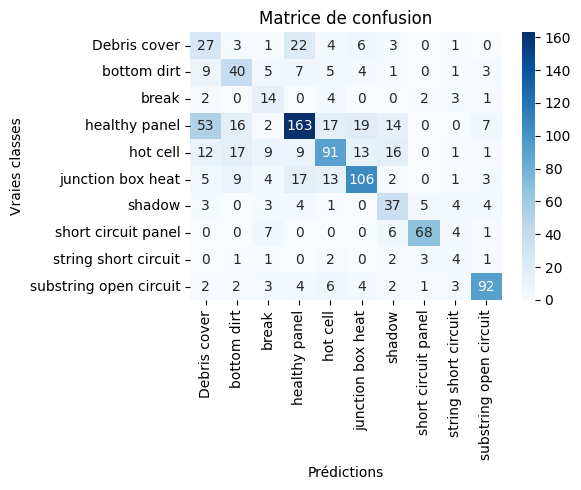

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.24      0.40      0.30        67
           bottom dirt       0.45      0.53      0.49        75
                 break       0.29      0.54      0.37        26
         healthy panel       0.72      0.56      0.63       291
              hot cell       0.64      0.54      0.58       169
     junction box heat       0.70      0.66      0.68       160
                shadow       0.45      0.61      0.51        61
   short circuit panel       0.86      0.79      0.82        86
  string short circuit       0.18      0.29      0.22        14
substring open circuit       0.81      0.77      0.79       119

              accuracy                           0.60      1068
             macro avg       0.53      0.57      0.54      1068
          weighted avg       0.64      0.60      0.62      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
35,DecisionTreeClassifier_AlbumentationsOverSampl...,1,{'features__edgedensity': EdgeDensityExtractor...,5.965799,0.234574,0.620609,0.010154,0.555988,0.021034,0.601124,0.541097,0.615294
32,DecisionTreeClassifier_AlbumentationsOverSampl...,2,{'features__edgedensity': EdgeDensityExtractor...,6.648561,0.452984,0.620375,0.018639,0.554783,0.022284,NaN,NaN,NaN
82,DecisionTreeClassifier_AlbumentationsOverSampl...,3,"{'features__edgedensity': 'drop', 'features__e...",4.773935,0.142381,0.609133,0.011483,0.552266,0.014925,NaN,NaN,NaN
33,DecisionTreeClassifier_AlbumentationsOverSampl...,4,{'features__edgedensity': EdgeDensityExtractor...,6.454630,0.112284,0.611007,0.013297,0.551826,0.018201,NaN,NaN,NaN
34,DecisionTreeClassifier_AlbumentationsOverSampl...,5,{'features__edgedensity': EdgeDensityExtractor...,5.442948,0.177797,0.608665,0.010768,0.550906,0.017032,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
87,DecisionTreeClassifier_AlbumentationsOverSampl...,92,"{'features__edgedensity': 'drop', 'features__e...",11.375215,1.233052,0.529040,0.022284,0.457804,0.017609,NaN,NaN,NaN
93,DecisionTreeClassifier_AlbumentationsOverSampl...,93,"{'features__edgedensity': 'drop', 'features__e...",4.352842,0.084426,0.532787,0.012677,0.457448,0.017944,NaN,NaN,NaN
88,DecisionTreeClassifier_AlbumentationsOverSampl...,94,"{'features__edgedensity': 'drop', 'features__e...",11.561019,0.852260,0.528806,0.025284,0.456319,0.021378,NaN,NaN,NaN
95,DecisionTreeClassifier_AlbumentationsOverSampl...,95,"{'features__edgedensity': 'drop', 'features__e...",2.996934,0.065410,0.532084,0.013177,0.456043,0.016259,NaN,NaN,NaN


🏃 View run secretive-frog-360_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/5533026d272242fdb26dd652f678eee0
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-frog-360_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/d7a31a0d25684789ba76cd7687b44010
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-frog-360_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/1b78135468c24d7986092b5b00c6973d
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-frog-360_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/d8220e66c0264c20a391c6c7c0e0c3cb
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-fro

🏃 View run secretive-frog-360_35 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/bbad3dbceeea46f59a7e2c56307d3a01
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-frog-360_36 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/da8957a9b2c34ff1bb561a1466908812
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-frog-360_37 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/a39f0f996a8048a4a31c406eb2a12613
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive-frog-360_38 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/2b5fe806fa3b4c6eb0e14f719cdd830a
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run secretive

🏃 View run secretive-frog-360_95 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/2be6b33017a04f07ac06915fb3180588
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305


🏃 View run secretive-frog-360 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/ec70b6537c3e42bfa002a7e62dbd0a87
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305

-------------------------------------------------------------------------
Evaluation des pipelines basés sur DecisionTreeClassifier
-------------------------------------------------------------------------

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Temps nécessaire : 4.91 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'features__histogram': [HistogramExtractor(), 'drop'],
                         'features__hotspots': [HotSpotsExtractor(), 'drop'],
                         'features__stats': [BaseStatsExtractor()],
                         'model': [DecisionTreeClassifier()],
                         'sampler': ['passthrough'],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': DecisionTreeClassifier(),
 'sampler': 'passthrough',
 'scaler': StandardScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.5875842701720536

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


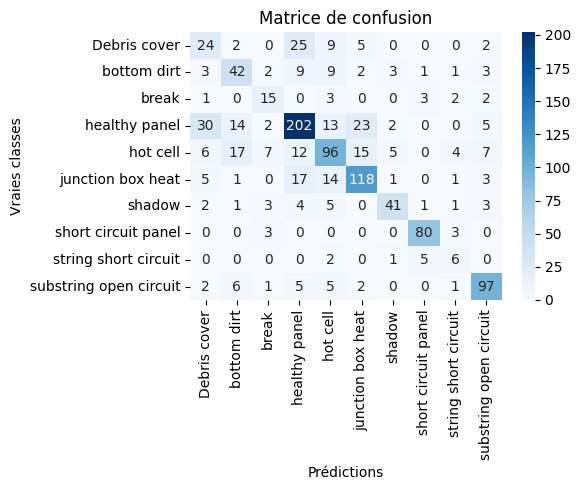

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.33      0.36      0.34        67
           bottom dirt       0.51      0.56      0.53        75
                 break       0.45      0.58      0.51        26
         healthy panel       0.74      0.69      0.72       291
              hot cell       0.62      0.57      0.59       169
     junction box heat       0.72      0.74      0.73       160
                shadow       0.77      0.67      0.72        61
   short circuit panel       0.89      0.93      0.91        86
  string short circuit       0.32      0.43      0.36        14
substring open circuit       0.80      0.82      0.80       119

              accuracy                           0.68      1068
             macro avg       0.61      0.63      0.62      1068
          weighted avg       0.68      0.68      0.68      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
33,DecisionTreeClassifier_noSampling_Stats_noHist...,1,{'features__edgedensity': EdgeDensityExtractor...,1.114887,0.496816,0.663700,0.016780,0.587584,0.023355,0.675094,0.621195,0.677069
35,DecisionTreeClassifier_noSampling_Stats_noHist...,2,{'features__edgedensity': EdgeDensityExtractor...,2.718816,0.528927,0.661827,0.012963,0.587298,0.012937,NaN,NaN,NaN
83,DecisionTreeClassifier_noSampling_Stats_noHist...,3,"{'features__edgedensity': 'drop', 'features__e...",3.334275,0.450088,0.663466,0.017983,0.585085,0.025055,NaN,NaN,NaN
81,DecisionTreeClassifier_noSampling_Stats_noHist...,4,"{'features__edgedensity': 'drop', 'features__e...",1.017271,0.618170,0.660422,0.017001,0.584589,0.025053,NaN,NaN,NaN
32,DecisionTreeClassifier_noSampling_Stats_noHist...,5,{'features__edgedensity': EdgeDensityExtractor...,1.591513,0.378421,0.660187,0.012065,0.583187,0.023364,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
88,DecisionTreeClassifier_noSampling_Stats_Histog...,92,"{'features__edgedensity': 'drop', 'features__e...",3.702394,1.277330,0.615691,0.017168,0.513052,0.013997,NaN,NaN,NaN
95,DecisionTreeClassifier_noSampling_Stats_noHist...,93,"{'features__edgedensity': 'drop', 'features__e...",0.760537,0.561931,0.607494,0.008744,0.512916,0.011747,NaN,NaN,NaN
87,DecisionTreeClassifier_noSampling_Stats_Histog...,94,"{'features__edgedensity': 'drop', 'features__e...",3.088255,1.009176,0.614286,0.013607,0.511265,0.010123,NaN,NaN,NaN
84,DecisionTreeClassifier_noSampling_Stats_Histog...,95,"{'features__edgedensity': 'drop', 'features__e...",4.930468,1.657365,0.613583,0.016920,0.511142,0.022208,NaN,NaN,NaN


🏃 View run luminous-fly-892_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/ee6b270ce1fd499198b79573c18a680b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/ce114595691a43169e8b0e8a1333a8d6
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/14016d38be4a415ea75fe9c55a511f40
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/5fdf6fbb5be24f2bbfb1179d2dbfbac8
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_4 at

🏃 View run luminous-fly-892_33 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/d735e29ed242465eb874059fd93e21a2
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_34 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/1a635fb6b98545b5a0de76ba3bbf722f
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_35 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/a19670be193d4ca08a50b4f971c55dda
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_36 at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305/runs/78ba512f8b8241cb82361158c663896c
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/666272109222650305
🏃 View run luminous-fly-892_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                               validate=False)],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': HotSpotsExtractor(),
 'features__stats': BaseStatsExtractor(),
 'model': RandomForestClassifier(),
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                          validate=False),
 'scaler': MinMaxScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.6880914352350423

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


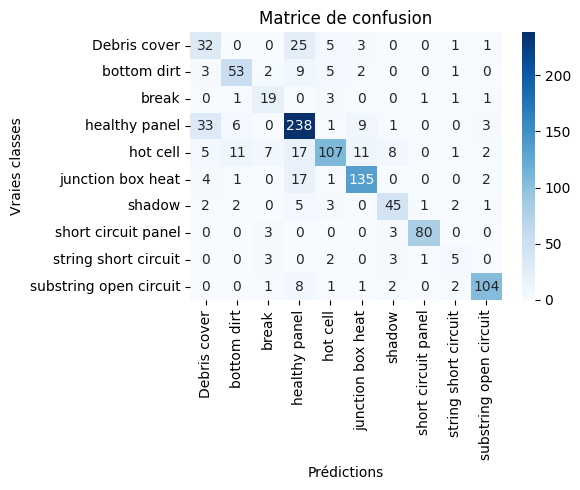

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.41      0.48      0.44        67
           bottom dirt       0.72      0.71      0.71        75
                 break       0.54      0.73      0.62        26
         healthy panel       0.75      0.82      0.78       291
              hot cell       0.84      0.63      0.72       169
     junction box heat       0.84      0.84      0.84       160
                shadow       0.73      0.74      0.73        61
   short circuit panel       0.96      0.93      0.95        86
  string short circuit       0.38      0.36      0.37        14
substring open circuit       0.91      0.87      0.89       119

              accuracy                           0.77      1068
             macro avg       0.71      0.71      0.71      1068
          weighted avg       0.78      0.77      0.77      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
31,RandomForestClassifier_AlbumentationsOverSampl...,1,{'features__edgedensity': EdgeDensityExtractor...,10.640252,0.382833,0.763466,0.020091,0.688091,0.022291,0.765918,0.705623,0.767621
10,RandomForestClassifier_AlbumentationsOverSampl...,2,{'features__edgedensity': EdgeDensityExtractor...,12.957247,0.506961,0.770023,0.016303,0.687159,0.023007,NaN,NaN,NaN
8,RandomForestClassifier_AlbumentationsOverSampl...,3,{'features__edgedensity': EdgeDensityExtractor...,14.543905,0.537543,0.763934,0.017472,0.686258,0.026626,NaN,NaN,NaN
49,RandomForestClassifier_AlbumentationsOverSampl...,4,"{'features__edgedensity': 'drop', 'features__e...",20.936729,0.861294,0.767447,0.021150,0.686187,0.022526,NaN,NaN,NaN
34,RandomForestClassifier_AlbumentationsOverSampl...,5,{'features__edgedensity': EdgeDensityExtractor...,10.838999,0.131283,0.761358,0.023224,0.684592,0.027192,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
46,RandomForestClassifier_AlbumentationsOverSampl...,92,{'features__edgedensity': EdgeDensityExtractor...,9.154387,0.186120,0.686417,0.019572,0.592520,0.022118,NaN,NaN,NaN
47,RandomForestClassifier_AlbumentationsOverSampl...,93,{'features__edgedensity': EdgeDensityExtractor...,8.972563,0.599619,0.685480,0.020384,0.591529,0.027299,NaN,NaN,NaN
93,RandomForestClassifier_AlbumentationsOverSampl...,94,"{'features__edgedensity': 'drop', 'features__e...",7.125036,0.240504,0.669087,0.015980,0.572750,0.021890,NaN,NaN,NaN
95,RandomForestClassifier_AlbumentationsOverSampl...,95,"{'features__edgedensity': 'drop', 'features__e...",4.961822,0.067758,0.667681,0.016249,0.570332,0.023417,NaN,NaN,NaN


🏃 View run enchanting-gnat-507_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/952380ebafc740cc843861d489f4e14f
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchanting-gnat-507_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/61afeea6331c454b98c880125f1c024e
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchanting-gnat-507_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/7a2894a97fbf448dbb3ee97aff6a973d
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchanting-gnat-507_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/14dd93a8d0494492946c3dfbfcacafd1
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchantin

🏃 View run enchanting-gnat-507_31 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/32c367271b1541419f7a9891c7776ff8
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchanting-gnat-507_32 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/6a181ce455e642759b483f29b6050fa0
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchanting-gnat-507_33 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/adc2f1f20be8433ab751fa04df7f7d59
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run enchanting-gnat-507_34 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/d57081a68d734cf689b91f08dd4792de
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run encha

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'features__histogram': [HistogramExtractor(), 'drop'],
                         'features__hotspots': [HotSpotsExtractor(), 'drop'],
                         'features__stats': [BaseStatsExtractor()],
                         'model': [RandomForestClassifier()],
                         'sampler': ['passthrough'],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': RandomForestClassifier(),
 'sampler': 'passthrough',
 'scaler': MinMaxScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.703217008094946

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


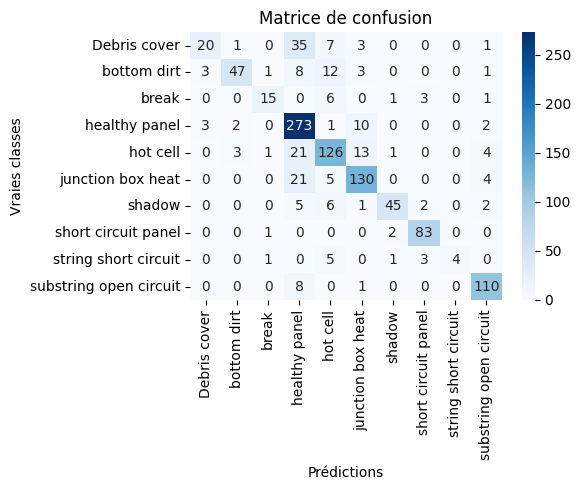

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.77      0.30      0.43        67
           bottom dirt       0.89      0.63      0.73        75
                 break       0.79      0.58      0.67        26
         healthy panel       0.74      0.94      0.82       291
              hot cell       0.75      0.75      0.75       169
     junction box heat       0.81      0.81      0.81       160
                shadow       0.90      0.74      0.81        61
   short circuit panel       0.91      0.97      0.94        86
  string short circuit       1.00      0.29      0.44        14
substring open circuit       0.88      0.92      0.90       119

              accuracy                           0.80      1068
             macro avg       0.84      0.69      0.73      1068
          weighted avg       0.81      0.80      0.79      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
34,RandomForestClassifier_noSampling_Stats_noHist...,1,{'features__edgedensity': EdgeDensityExtractor...,6.445448,0.413952,0.792740,0.017882,0.703217,0.021805,0.798689,0.730841,0.787302
33,RandomForestClassifier_noSampling_Stats_noHist...,2,{'features__edgedensity': EdgeDensityExtractor...,4.994922,0.607117,0.789696,0.016336,0.698961,0.021965,NaN,NaN,NaN
35,RandomForestClassifier_noSampling_Stats_noHist...,3,{'features__edgedensity': EdgeDensityExtractor...,7.526452,0.575799,0.789461,0.018312,0.697321,0.021635,NaN,NaN,NaN
32,RandomForestClassifier_noSampling_Stats_noHist...,4,{'features__edgedensity': EdgeDensityExtractor...,6.249667,0.254388,0.791101,0.017659,0.692652,0.031254,NaN,NaN,NaN
31,RandomForestClassifier_noSampling_Stats_noHist...,5,{'features__edgedensity': EdgeDensityExtractor...,6.531473,0.592356,0.792272,0.018360,0.691886,0.024267,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
87,RandomForestClassifier_noSampling_Stats_Histog...,92,"{'features__edgedensity': 'drop', 'features__e...",10.064441,1.016310,0.747775,0.015825,0.614641,0.013841,NaN,NaN,NaN
88,RandomForestClassifier_noSampling_Stats_Histog...,93,"{'features__edgedensity': 'drop', 'features__e...",10.292007,0.576975,0.748946,0.018089,0.612822,0.021585,NaN,NaN,NaN
93,RandomForestClassifier_noSampling_Stats_noHist...,94,"{'features__edgedensity': 'drop', 'features__e...",3.231671,0.444188,0.726932,0.013069,0.595960,0.018850,NaN,NaN,NaN
94,RandomForestClassifier_noSampling_Stats_noHist...,95,"{'features__edgedensity': 'drop', 'features__e...",3.304261,0.170470,0.725995,0.010884,0.592130,0.015389,NaN,NaN,NaN


🏃 View run bouncy-hound-973_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/da5a09e7e6ee468da8494c5ea35061cc
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/01032fe67d244dc3a273cc0461a7102d
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/6daa72ef5448416184ce8cc200d3e0b5
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/018e28139fab4ff39ac86c037bc9d485
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_4 at

e:\Miniconda3\envs\DS_Project_Git\Lib\site-packages\mlflow\models\model.py:365: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


🏃 View run bouncy-hound-973_34 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/c2cce0b53a0a4ede8e5d54fa6c2a36cb
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_35 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/044a453ca22143f48ef1b5b6b245282b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_36 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/ff4e61087f4c4aa5be0033834ce681ab
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_37 at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914/runs/304b943118f447b890dd0cd5eaf774ed
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/613062705066808914
🏃 View run bouncy-hound-973_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'sampler': [AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                               validate=False)],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': 'drop',
 'features__glcm': GLCMExtractor(),
 'features__histogram': 'drop',
 'features__hotspots': 'drop',
 'features__stats': BaseStatsExtractor(),
 'model': XGBClassifierWithLabelEncoding(eval_metric='logloss', tree_method='hist'),
 'sampler': AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                          validate=False),
 'scaler': RobustScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.7144050446385953

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


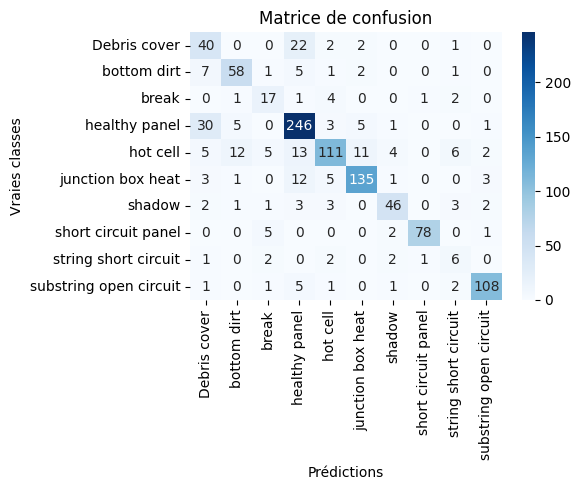

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.45      0.60      0.51        67
           bottom dirt       0.74      0.77      0.76        75
                 break       0.53      0.65      0.59        26
         healthy panel       0.80      0.85      0.82       291
              hot cell       0.84      0.66      0.74       169
     junction box heat       0.87      0.84      0.86       160
                shadow       0.81      0.75      0.78        61
   short circuit panel       0.97      0.91      0.94        86
  string short circuit       0.29      0.43      0.34        14
substring open circuit       0.92      0.91      0.92       119

              accuracy                           0.79      1068
             macro avg       0.72      0.74      0.73      1068
          weighted avg       0.81      0.79      0.80      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
35,XGBClassifierWithLabelEncoding_AlbumentationsO...,1,{'features__edgedensity': EdgeDensityExtractor...,11.521533,0.265115,0.784543,0.013656,0.714405,0.015450,0.791199,0.725216,0.795658
9,XGBClassifierWithLabelEncoding_AlbumentationsO...,2,{'features__edgedensity': EdgeDensityExtractor...,25.176199,0.296413,0.785948,0.009291,0.713397,0.008430,NaN,NaN,NaN
33,XGBClassifierWithLabelEncoding_AlbumentationsO...,3,{'features__edgedensity': EdgeDensityExtractor...,16.014200,0.108189,0.782904,0.016553,0.712813,0.018489,NaN,NaN,NaN
34,XGBClassifierWithLabelEncoding_AlbumentationsO...,4,{'features__edgedensity': EdgeDensityExtractor...,17.096494,0.222023,0.783138,0.016715,0.712428,0.018417,NaN,NaN,NaN
11,XGBClassifierWithLabelEncoding_AlbumentationsO...,5,{'features__edgedensity': EdgeDensityExtractor...,34.025971,0.209415,0.785480,0.012178,0.712023,0.011665,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
47,XGBClassifierWithLabelEncoding_AlbumentationsO...,92,{'features__edgedensity': EdgeDensityExtractor...,24.156414,0.342557,0.697190,0.021098,0.614846,0.021094,NaN,NaN,NaN
45,XGBClassifierWithLabelEncoding_AlbumentationsO...,92,{'features__edgedensity': EdgeDensityExtractor...,12.298209,0.263132,0.697190,0.021098,0.614846,0.021094,NaN,NaN,NaN
94,XGBClassifierWithLabelEncoding_AlbumentationsO...,94,"{'features__edgedensity': 'drop', 'features__e...",8.483020,0.060083,0.674005,0.013627,0.577473,0.018963,NaN,NaN,NaN
93,XGBClassifierWithLabelEncoding_AlbumentationsO...,95,"{'features__edgedensity': 'drop', 'features__e...",9.311272,0.074009,0.671429,0.012711,0.575973,0.019042,NaN,NaN,NaN


🏃 View run legendary-asp-659_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/210b73db6ee342fe9f6edfda049f143d
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/5f6e848657144b32a8c2aeeaf5bf874d
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/5e1a703bcb754120a6e999e6cf65d29f
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/f6d2927cf16c45cc89d528a491e2c9a7
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659

e:\Miniconda3\envs\DS_Project_Git\Lib\site-packages\mlflow\models\model.py:365: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


🏃 View run legendary-asp-659_35 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/ec755c58f1ae49e8b36592bb57e96511
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659_36 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/af8c380ddded4d6091799b587234900b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659_37 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/e7cec471f8ab4c14b8294a577353e001
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp-659_38 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/8587906ad73445aa88cf55519ae28da9
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run legendary-asp

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        AlbumentationsOverSampler(func=<bound method AlbumentationsAugmenter.resample of <__main__.AlbumentationsAugmenter object at 0x000001151D89A0F0>>,
                                                                  validate=False)),
                                       ('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('histogra...
                         'features__hotspots': [HotSpotsExtractor(), 'drop'],
                         'features__stats': [BaseStatsExtractor()],
                         'model': [XGBClassifierWithLabelEncoding(eval_metric='logloss',
                                                                  tree_method='hist')],
                         'sampler': ['passthrough'],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler()],
                         'selector': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'features__edgedensity': EdgeDensityExtractor(),
 'features__entropy': EntropyExtractor(),
 'features__glcm': GLCMExtractor(),
 'features__histogram': HistogramExtractor(),
 'features__hotspots': HotSpotsExtractor(),
 'features__stats': BaseStatsExtractor(),
 'model': XGBClassifierWithLabelEncoding(eval_metric='logloss', tree_method='hist'),
 'sampler': 'passthrough',
 'scaler': RobustScaler(),
 'selector': 'passthrough'}
Meilleur score (f1 macro):  0.7237004016308323

--------------------------------
Résultats obtenus sur le jeu de test, pour le meilleur estimateur trouvé :


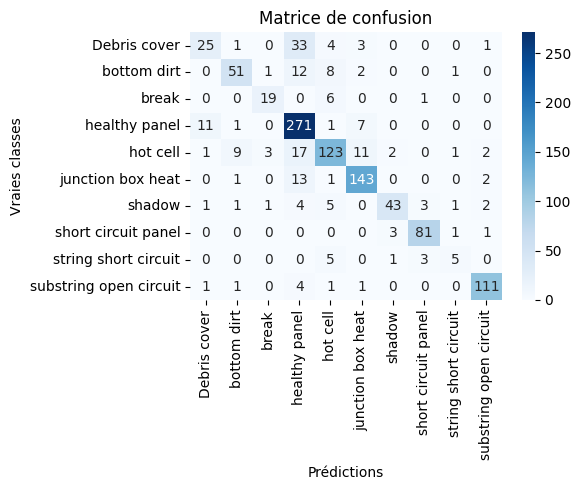

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.64      0.37      0.47        67
           bottom dirt       0.78      0.68      0.73        75
                 break       0.79      0.73      0.76        26
         healthy panel       0.77      0.93      0.84       291
              hot cell       0.80      0.73      0.76       169
     junction box heat       0.86      0.89      0.87       160
                shadow       0.88      0.70      0.78        61
   short circuit panel       0.92      0.94      0.93        86
  string short circuit       0.56      0.36      0.43        14
substring open circuit       0.93      0.93      0.93       119

              accuracy                           0.82      1068
             macro avg       0.79      0.73      0.75      1068
          weighted avg       0.81      0.82      0.81      1068



,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,test_accuracy,test_f1_macro,test_f1_weighted
2,XGBClassifierWithLabelEncoding_noSampling_Stat...,1,{'features__edgedensity': EdgeDensityExtractor...,49.070830,2.076344,0.814520,0.017768,0.723700,0.028097,0.816479,0.751722,0.809021
1,XGBClassifierWithLabelEncoding_noSampling_Stat...,2,{'features__edgedensity': EdgeDensityExtractor...,50.009173,2.717829,0.814520,0.017783,0.723347,0.028741,NaN,NaN,NaN
56,XGBClassifierWithLabelEncoding_noSampling_Stat...,3,"{'features__edgedensity': 'drop', 'features__e...",16.082363,0.470957,0.811007,0.013985,0.723149,0.023376,NaN,NaN,NaN
10,XGBClassifierWithLabelEncoding_noSampling_Stat...,4,{'features__edgedensity': EdgeDensityExtractor...,14.680848,0.460379,0.809368,0.015787,0.722599,0.022441,NaN,NaN,NaN
0,XGBClassifierWithLabelEncoding_noSampling_Stat...,5,{'features__edgedensity': EdgeDensityExtractor...,50.048257,2.639401,0.814052,0.017934,0.722251,0.028285,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
91,XGBClassifierWithLabelEncoding_noSampling_Stat...,92,"{'features__edgedensity': 'drop', 'features__e...",9.447303,0.245719,0.754098,0.018321,0.645174,0.030517,NaN,NaN,NaN
92,XGBClassifierWithLabelEncoding_noSampling_Stat...,93,"{'features__edgedensity': 'drop', 'features__e...",6.704231,0.246903,0.751991,0.022358,0.644552,0.034443,NaN,NaN,NaN
94,XGBClassifierWithLabelEncoding_noSampling_Stat...,94,"{'features__edgedensity': 'drop', 'features__e...",4.830250,0.078205,0.731850,0.022645,0.627255,0.038223,NaN,NaN,NaN
93,XGBClassifierWithLabelEncoding_noSampling_Stat...,95,"{'features__edgedensity': 'drop', 'features__e...",6.030874,0.192832,0.731616,0.022443,0.626524,0.037572,NaN,NaN,NaN


🏃 View run industrious-auk-209_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/bb2a6a46c19445a3b4952c94e86c4b1c
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/c2dd99e8f1a64cd89b539c836abf14fc
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468


e:\Miniconda3\envs\DS_Project_Git\Lib\site-packages\mlflow\models\model.py:365: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


🏃 View run industrious-auk-209_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/0569d43297994a7a9deefc2a0a55f4d7
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/e496206eb3eb434a8b5d9eb67da9b477
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_4 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/30dc682aa42a44f7a3d9d05098af2aeb
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_5 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/a5c553f94c694f0bb61eae4d4bd2e54a
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrio

🏃 View run industrious-auk-209_61 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/fac12d4d44dd41ca88b3713b41830f3a
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_62 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/294333a31f23451a8d2d625d4b88f336
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_63 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/f8155ad46af7411d9893a77a75e9be15
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run industrious-auk-209_64 at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468/runs/347da618f1c846ecb9543b277e755fa7
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/781650816726710468
🏃 View run indus

In [79]:
import mlflow.sklearn
import mlflow.sklearn.utils
from joblib import parallel_backend

results_list = []

mlflow_client = mlflow.tracking.MlflowClient()

for param_grid in param_grids:

    # Perform GridSearchCV
    with parallel_backend('threading'):  # Important pour permettre le "partage" de la classe PVModule entre tous les jobs
        current_grid, current_results, figure, report_text, report_dict = execute_gridsearch(param_grid)

    # Append results to the full list
    results_list.append(current_results)

    if ACTIVATE_MLFLOW:

        base_model = param_grid.get('model')[0]
        model_name = base_model.__class__.__name__
        
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(model_name=model_name,
                                                                    # date_string=current_dt.format('YYYYMMDD_HHmm'),
                                                                    date_string=current_dt.format('YYYYMMDD'),
                                                                    )
                              )
        mlflow.set_experiment_tag("estimator", model_name)

        with mlflow.start_run() as parent_run:

            n_candidates = len(current_results['params'])
            best_index = current_grid.best_index_

            # Log parameters grid and additional gridsearch parameters
            mlflow.log_params(param_grid)
            mlflow.log_param("cv", current_grid.cv)
            mlflow.log_param("scoring", current_grid.scoring)
            mlflow.log_param("total_candidates", n_candidates)

            # Log cv global results
            with tempfile.TemporaryDirectory() as tmp_dir:
                results_path = Path(tmp_dir) / "cv_results.csv"
                current_results.to_csv(results_path, index=False)
                mlflow.log_artifact(results_path)

            for i in range(n_candidates):

                params = current_results.loc[i, 'params']

                with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                    
                    # Log pipeline description as tag
                    mlflow.set_tag("description", current_results.loc[i, "pipeline_description"])

                    # Log hyperparameters
                    mlflow.log_params(params)

                    # Log mean and std scores, mean and std times, ranks, split_scores
                    for name in current_results.columns:
                        if name.startswith(("mean_test_", "rank_test_", "std_test_")) or name.endswith("_time"):
                            mlflow.log_metric(name, current_results.loc[i, name])

                    # If it's the best estimator
                    if i == best_index:

                        # Log the model
                        best_model = current_grid.best_estimator_
                        mlflow.sklearn.log_model(best_model, artifact_path="model", input_example=X_train[["Chemin"]])
                        mlflow.set_tag("is_best", True)

                        # Log pipeline html representation
                        mlflow.sklearn.utils._log_estimator_html(child_run.info.run_id, best_model)

                        # Log test metrics
                        for score_name in [name for name in current_results.columns if name.startswith("test_")]:
                            mlflow.log_metric(score_name, current_results.loc[i, score_name])
                        # Log classification matrix
                        with tempfile.TemporaryDirectory() as tmp_dir:
                            cm_path = Path(tmp_dir) / "confusion_matrix.png"
                            figure.savefig(cm_path)
                            mlflow.log_artifact(cm_path)
                        # Log classification reports
                        mlflow.log_text(report_text, "classification_report.txt")
                        mlflow.log_dict(report_dict, "classification_report.yaml")

                    else:
                        mlflow.set_tag("is_best", False)


## Compilation des résultats

In [80]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,mean_train_f1_macro,std_train_f1_macro,pipeline_description,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted
0,13.339358,0.029644,1.685829,0.351076,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),HotSpotsExtractor(),BaseStatsExtractor(),...,1.0,0.0,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.266530,0.081156,1.558786,0.230264,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),HotSpotsExtractor(),BaseStatsExtractor(),...,1.0,0.0,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13.310868,0.105143,1.659282,0.350281,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),HotSpotsExtractor(),BaseStatsExtractor(),...,1.0,0.0,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.726989,0.082624,1.348192,0.100063,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),drop,BaseStatsExtractor(),...,1.0,0.0,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.882672,1.165806,1.139019,0.478390,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),drop,BaseStatsExtractor(),...,1.0,0.0,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,9.447303,2.018236,0.245719,0.174844,drop,drop,drop,drop,HotSpotsExtractor(),BaseStatsExtractor(),...,1.0,0.0,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,6.704231,0.400375,0.246903,0.142216,drop,drop,drop,drop,HotSpotsExtractor(),BaseStatsExtractor(),...,1.0,0.0,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573,6.030874,0.153659,0.192832,0.110442,drop,drop,drop,drop,drop,BaseStatsExtractor(),...,1.0,0.0,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
574,4.830250,0.424775,0.078205,0.089051,drop,drop,drop,drop,drop,BaseStatsExtractor(),...,1.0,0.0,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sauvegarde du fichier de résultats

In [81]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmm')}.csv"
results_df.to_csv(filepath, index=False, sep=";")

# Exploration des résultats

In [82]:
results_df['model_name'] = results_df['param_model'].apply(lambda model_object: model_object.__class__.__name__)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"   {k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [83]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_features__edgedensity,param_features__entropy,param_features__glcm,param_features__histogram,param_features__hotspots,param_features__stats,...,pipeline_description,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,model_name,params_str
0,13.339358,0.029644,1.685829,0.351076,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),HotSpotsExtractor(),BaseStatsExtractor(),...,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
1,13.266530,0.081156,1.558786,0.230264,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),HotSpotsExtractor(),BaseStatsExtractor(),...,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
2,13.310868,0.105143,1.659282,0.350281,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),HotSpotsExtractor(),BaseStatsExtractor(),...,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
3,12.726989,0.082624,1.348192,0.100063,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),drop,BaseStatsExtractor(),...,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
4,11.882672,1.165806,1.139019,0.478390,EdgeDensityExtractor(),EntropyExtractor(),GLCMExtractor(),HistogramExtractor(),drop,BaseStatsExtractor(),...,DecisionTreeClassifier_AlbumentationsOverSampl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DecisionTreeClassifier,<br> features__edgedensity=EdgeDensityExtrac...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,9.447303,2.018236,0.245719,0.174844,drop,drop,drop,drop,HotSpotsExtractor(),BaseStatsExtractor(),...,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XGBClassifierWithLabelEncoding,<br> features__edgedensity=drop<br> featur...
572,6.704231,0.400375,0.246903,0.142216,drop,drop,drop,drop,HotSpotsExtractor(),BaseStatsExtractor(),...,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XGBClassifierWithLabelEncoding,<br> features__edgedensity=drop<br> featur...
573,6.030874,0.153659,0.192832,0.110442,drop,drop,drop,drop,drop,BaseStatsExtractor(),...,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XGBClassifierWithLabelEncoding,<br> features__edgedensity=drop<br> featur...
574,4.830250,0.424775,0.078205,0.089051,drop,drop,drop,drop,drop,BaseStatsExtractor(),...,XGBClassifierWithLabelEncoding_noSampling_Stat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XGBClassifierWithLabelEncoding,<br> features__edgedensity=drop<br> featur...


In [84]:
# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "⏱️ Précision vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "mean_test_f1_macro": "⏱️ F1_macro vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "test_accuracy": "⏱️ Précision vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de test",
    "test_f1_macro": "⏱️ F1_macro vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de test",
}

In [85]:
import plotly.express as px
import plotly.graph_objects as go

# Création du graphique interactif pour chaque cas

for score, title in scores.items():
    
    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score].idxmax()
    best_row = results_df.loc[best_idx]

    fig = px.scatter(
        results_df,
        x='mean_fit_time',
        y=score,
        color='model_name',
        hover_data={
            'model_name': True,
            'params_str': True,
            'mean_fit_time': ':.2f',
            score: ':.4f',
        },
        title=title
    )
    fig.update_traces(marker=dict(size=7, line=dict(width=1, color='DarkSlateGrey')))

    # Ajouter un marqueur spécial pour le meilleur point
    fig.add_trace(go.Scatter(
        x=[best_row['mean_fit_time']],
        y=[best_row[score]],
        mode='markers+text',
        marker=dict(
            color='red',
            size=12,
            symbol='star'
        ),
        # text=["🏆"],
        textposition="top center",
        hoverinfo='skip',  # pour ne pas gêner les tooltips de px
        showlegend=False
    ))

    fig.update_layout(legend_title_text='Modèle', height=600)
    fig.show()
